In [1]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
%matplotlib inline

### Load all the data

In [2]:
linguistic_features = pd.read_parquet("../linguistic_features3000.parquet")
linguistic_features.head(1)

,ctrate,offset_time_mean,page_id,tokens_vector_scaled
0,0.032468,73122.4,2644120,"[4.630754687237475, -0.4242843849230154, -0.26..."


In [3]:
import pickle
with open('../vocab3000.pickle', 'rb') as handle:
    vocab = pickle.load(handle)

In [4]:
words_count = pd.read_pickle("../vocab3000_counts.pickle")
words_count.head(1)

,varname,occurrences,articles
0,online,2117,1801


### Train the regression with high-low CTR based on the median

In [5]:
X = linguistic_features.tokens_vector_scaled.tolist()
y = linguistic_features.ctrate.tolist()

In [6]:
m = np.median(y)
mod = sm.Logit([1 if i >=m else 0 for i in y], sm.add_constant(X))
res = mod.fit()
print("No. Observations:", len(y))
print("Pseudo R-squ.:", res.prsquared)
print("LLR p-value:", res.llr_pvalue)

Optimization terminated successfully.
         Current function value: 0.477162
         Iterations 9
No. Observations: 111828
Pseudo R-squ.: 0.3116001108973031
LLR p-value: 0.0


In [7]:
err_series = res.params - np.array([x[0] for x in res.conf_int()])

coef_df = pd.DataFrame({'coef': res.params[1:],
                        'err': err_series[1:],
                        'varname': vocab
                       }).sort_values("coef", ascending=False)

coef_df = coef_df.merge(words_count, on="varname")
coef_df['perc'] = coef_df['articles']/coef_df['articles'].sum()
coef_df.head(15)

,coef,err,varname,occurrences,articles,perc
0,0.253613,0.027105,university,16249,7200,0.002976
1,0.208002,0.026267,company,18981,12308,0.005087
2,0.145897,0.023345,manufacturer,1645,1508,0.000623
3,0.134643,0.030629,airline,1494,920,0.000380
4,0.120807,0.023761,pornographic,251,225,0.000093
5,0.119762,0.018277,founded,12321,11911,0.004923
6,0.110142,0.029461,school,18294,6694,0.002767
7,0.108792,0.022029,headquartered,3740,3697,0.001528
8,0.095360,0.018095,based,14035,13163,0.005441
9,0.092713,0.022638,league,5943,3016,0.001247


Text(0.5, -0.25, 'Words in the leading section')

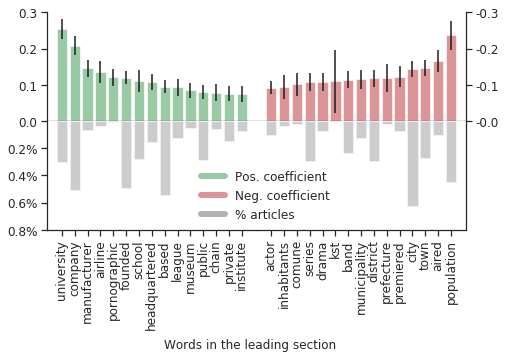

In [8]:
# plt.figure(figsize=(5, 4), frameon=False)
from matplotlib.lines import Line2D

sns.set_context("paper")
sns.set(font_scale = 1.1)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(7.5, 4))

top_bottom = coef_df.head(15).append(coef_df.tail(15))

positive_words = top_bottom[top_bottom.coef>0]
negative_words = top_bottom[top_bottom.coef<0]

ax1[0].bar(range(len(positive_words)), positive_words['coef'], 
           yerr=positive_words.err.tolist(), 
           alpha=0.6, color="g")
ax1[1].bar(range(len(negative_words)), -negative_words['coef'], 
           yerr=negative_words.err.tolist(), 
           alpha=0.6, color="r")
ax1[0].set_ylim((0, 0.3))
ax1[1].set_ylim((0, 0.3))

ax1[0].set_yticklabels(['0.0', '0.1', '0.2', '0.3'])


ax2[0].bar(range(len(positive_words)), -positive_words['perc'], alpha=0.4, color="grey")
ax2[1].bar(range(len(negative_words)), -negative_words['perc'], alpha=0.4, color="grey")


ax1[0].set_xticks([])
ax1[1].set_xticks([])

# ax1[1].set_yticks([])
ax2[1].set_yticks([])

ax2[0].set_xticks(range(len(positive_words)))
ax2[0].set_xticklabels(positive_words['varname'], rotation=90)

ax2[1].set_xticks(range(len(negative_words)))
ax2[1].set_xticklabels(negative_words['varname'], rotation=90)

for a in [ax1, ax2]:
    for i in [0,1]:
        a[i].spines['right'].set_visible(False)
        a[i].spines['top'].set_visible(False)
        

ax2[1].axes.yaxis.set_visible(False)

ax2[1].spines['left'].set_visible(False)
ax1[1].spines['left'].set_visible(False)

ax2[0].set_yticks(np.arange(-0.008, 0, 0.002))
ax2[0].set_yticklabels(["{:.1%}".format(-x) for x in np.arange(-0.008, 0, 0.002)])
ax2[1].set_yticks(np.arange(-0.008, 0, 0.002))
ax2[1].set_yticklabels([])


plt.subplots_adjust(wspace=0, hspace=0)

custom_lines = [Line2D([0], [0], color='g', lw=6, alpha=0.6),
                Line2D([0], [0], color='r', lw=6, alpha=0.6),
                Line2D([0], [0], color='grey', lw=6, alpha=0.6)]
ax2[1].legend(custom_lines, ['Pos. coefficient', 'Neg. coefficient', '% articles'], 
              bbox_to_anchor=(0.4, 0.65), fancybox=True, framealpha=1.0).get_frame().set_alpha(0)


ax1[1].yaxis.set_label_position("right")
ax1[1].yaxis.tick_right()
ax1[1].set_yticklabels(['-0.0', '-0.1', '-0.2', '-0.3'])
ax1[1].spines['right'].set_visible(True)
ax2[1].spines['right'].set_visible(True)
fig.suptitle("Words in the leading section", fontsize=12, y=-0.25)
# plt.savefig('linguistic_features_clicks.pdf', bbox_inches='tight')